In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../novelgraphs/'))

import novelgraphs as ng

import pandas as pd
from collections import defaultdict, Counter
from itertools import combinations
import networkx as nx
from operator import itemgetter
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from numpy import array_split
import numpy

In [4]:
with open('../text/Doyl/sher_eng.txt', encoding='utf-8') as file:
    sher = file.read()
    
a = sher.find('A SCANDAL IN BOHEMIA')
b = sher.find('THE RED-HEADED LEAGUE')
scandal = sher[a:b]

In [6]:
# scandal

In [7]:
# text = ng.Text.from_pickle('sher-iren-table.pickle')
text = ng.Text(scandal)

In [8]:
text.tags.head()

,SentenceID,TokenID,Token
0,0,0,A
1,0,1,SCANDAL
2,0,2,IN
3,0,3,BOHEMIA
4,0,4,Table


In [9]:
core = ng.annotators.CoreNLP()
np = ng.annotators.NerNpID()
ann = ng.annotators.Sentiment()
ann2 = ng.annotators.Dialog()
qq = ng.annotators.Quote()
fp = ng.annotators.FirstPerson()
char = ng.annotators.Character()

In [10]:
pipeline = ng.annotators.Pipeline([core, np, ann, qq, ann2, fp, char])
pipeline.annotate(text)

In [11]:
text.to_pickle('sher-iren-table.pickle')

In [12]:
dialog = ng.interaction.extractors.Dialog()
sentences = ng.interaction.extractors.Sentences()
sent_dist = ng.interaction.extractors.SentenceDistance()
tokens = ng.interaction.extractors.TokenDistance()
seq = ng.interaction.extractors.TokenSequence()
dep = ng.interaction.extractors.TokenDependencies()

count = ng.interaction.aggregators.Count()
sentiment = ng.interaction.aggregators.Sentiment()

In [13]:
def graph_weights(graph):
    return [edge[2]['weight'] for edge in graph.edges(data=True)]

### Rolling window

In [14]:
def rolling_window_slices(window_size, step, length):
    if length <= 18000:
        window_size = 3000
        step = 1000
    
    num_slices = max((length - window_size) // step, 0)
    return ([slice(i * step, i * step + window_size) for i in range(num_slices)] +
             [slice(num_slices * step, length)])

In [15]:
rolling_window_slices(10000, 1000, len(text.tags))[:5]

[slice(0, 3000, None),
 slice(1000, 4000, None),
 slice(2000, 5000, None),
 slice(3000, 6000, None),
 slice(4000, 7000, None)]

### Negative graph plot

In [44]:
novelgraph2 = ng.NovelGraph(dialog, sentiment)

In [70]:
novelgraph = ng.NovelGraph(sent_dist, sentiment)

In [71]:
def get_chapters(window_size, step, length):
    chapters = []
    for slice_t in rolling_window_slices(window_size, step, length):
        tags = text.tags.loc[slice_t]
        chapter = ng.Text('')
        chapter.characters = text.characters
        chapter.first_person = text.first_person
        chapter.tags = tags
        chapters.append(chapter)
    return chapters

In [72]:
chapters = get_chapters(10000, 1000, len(text.tags))

In [73]:
def get_negative_sentiment_balance(chapters):
    text_balance = []
    for i in range(len(chapters)):
        graph = novelgraph(chapters[i])
        weights = graph_weights(graph)
        if weights:
            balance = len([p for p in weights if p < 0]) / len(weights)
            text_balance.append(balance)
    return text_balance

In [74]:
def get_negative_sentiment_balance2(chapters):
    text_balance = []
    for i in range(len(chapters)):
        graph = novelgraph2(chapters[i])
        weights = graph_weights(graph)
        if weights:
            balance = len([p for p in weights if p < 0]) / len(weights)
            text_balance.append(balance)
    return text_balance

In [75]:
negative_graph_sd = get_negative_sentiment_balance(chapters)
negative_graph_di = get_negative_sentiment_balance2(chapters)

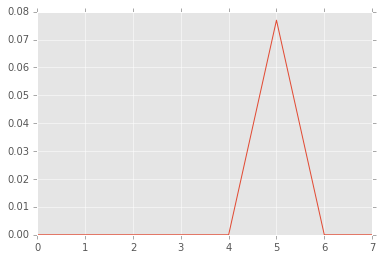

In [76]:
plt.plot(negative_graph_di)

- Мера сбалансированности: отношение значений < 0 ко всем значениям => чем ближе к 1, тем несбалансированней, чем ближе к 0 - тем ближе к балансу
    - tokens
    - sentences
    
- Seq и Dep могут оказаться пустыми!
    - seq периодически вылетает с ошибкой (добавить проверку i + 2 < len(text))
- количество "глав" должно быть разным для разных произведений (например, для коротких - 5, для длинных - больше)
- 10 хорошее количество глав, но лучше двигаться скользящим окном
- вопрос с nan

### Balanced graph plot

In [77]:
def get_cycles_from_graph(graph):
    cycles = []
    for cycle in nx.cycle_basis(graph):
        cycles.append(list(zip(cycle, cycle[1:])) + [(cycle[-1], cycle[0])])
    return cycles

def is_positive(cycle, graph):
    negatives = 0
    for edge in cycle:
        if graph.edge[edge[0]][edge[1]]['weight'] < 0:
            negatives += 1
    return not negatives % 2

def get_graph_balance(chapters):
    '''Считаем сбалансированность графа: 
    1. выделить простые циклы из графа
    2. определить знак цикла
    3. находим меру сбалансированности - долю положительных циклов среди всех
    '''
    balance_cycle = []
    for i in range(len(chapters)):
        graph = novelgraph(chapters[i])
        graph_cycles = get_cycles_from_graph(graph)
#         print(len(graph_cycles))
        balance = numpy.mean(
            [is_positive(cycle, graph) for cycle in graph_cycles])
        balance_cycle.append(balance)
#     print(balance_cycle) 
    return balance_cycle

In [78]:
def get_graph_balance2(chapters):
    '''Считаем сбалансированность графа: 
    1. выделить простые циклы из графа
    2. определить знак цикла
    3. находим меру сбалансированности - долю положительных циклов среди всех
    '''
    balance_cycle = []
    for i in range(len(chapters)):
        graph = novelgraph2(chapters[i])
        graph_cycles = get_cycles_from_graph(graph)
#         print(len(graph_cycles))
        balance = numpy.mean(
            [is_positive(cycle, graph) for cycle in graph_cycles])
        balance_cycle.append(balance)
#     print(balance_cycle) 
    return balance_cycle

In [79]:
balance = get_graph_balance(chapters)

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


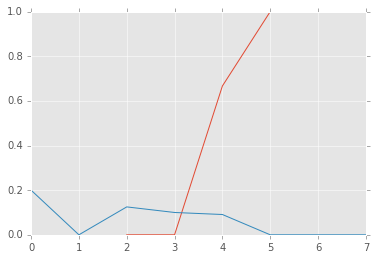

In [84]:
plt.plot(balance, label='Balance')
plt.plot(negative_graph_sd, label='Negative_sent')
# plt.legend()
plt.savefig('./projectgraphs/plot/balance_sher_iren.pdf')

3 -- рассказ короля о своих бедах, связанных с совместным фото с Ирен

In [56]:
balance2 = get_graph_balance2(chapters)

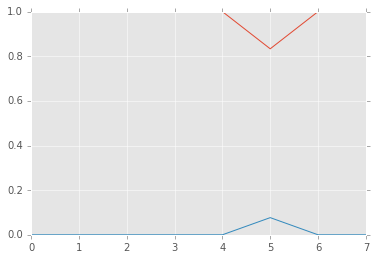

In [85]:
plt.plot(balance2, label='Balance')
plt.plot(negative_graph_di, label='Negative_sent')
plt.savefig('./projectgraphs/plot/balance_sher_iren_balance.pdf')

5 -- момент, когда Холмс, следуя за Ирен, становится свидетелем ее свадьбы

In [86]:
a = rolling_window_slices(10000, 1000, len(text.tags))

In [87]:
a[5]

slice(5000, 8000, None)

In [89]:
text.tags.loc[a[5], ['Token']]

,Token
5000,of
5001,Irene
5002,Adler
5003,?
5004,""""
5005,I
5006,asked
5007,.
5008,""""
5009,Oh


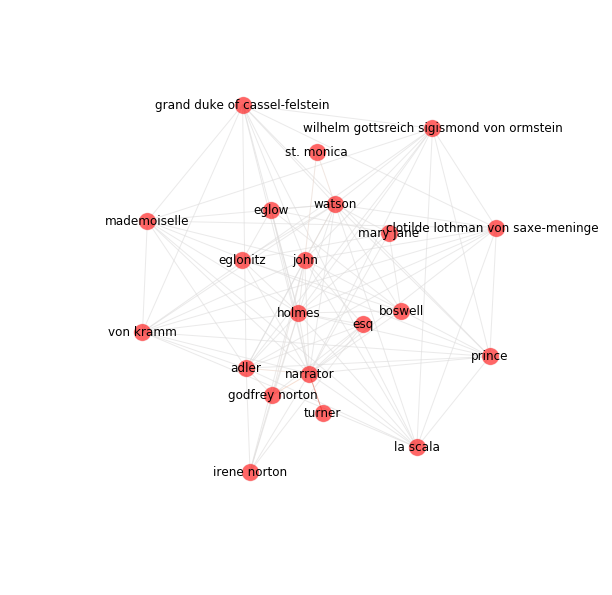

In [58]:
novelgraph = ng.NovelGraph(dialog, sentiment)
graph = novelgraph(text)

weights = graph_weights(graph)
plt.figure(figsize=(10,10))
plt.axis('off')
nx.draw_networkx(graph,
                 with_labels=True,
                 edge_color=weights,
                 edge_cmap=plt.cm.coolwarm,
                 edge_vmax = 0.5, edge_vmin=-0.5, alpha=0.6)
plt.show()

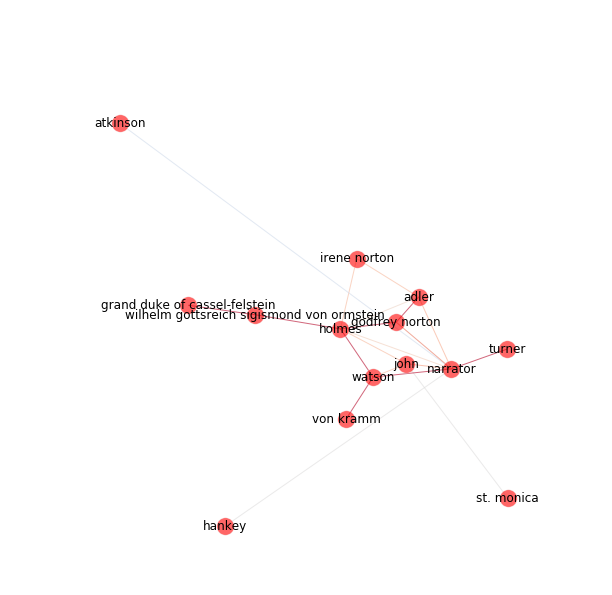

In [83]:
novelgraph = ng.NovelGraph(sent_dist, sentiment)
graph = novelgraph(text)

weights = graph_weights(graph)
plt.figure(figsize=(10,10))
plt.axis('off')
nx.draw_networkx(graph,
                 with_labels=True,
                 edge_color=weights,
                 edge_cmap=plt.cm.coolwarm,
                 edge_vmax = 0.5, edge_vmin=-0.5, alpha=0.6)
plt.show()